In [174]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pickle
import os
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create output directory
os.makedirs('../notebooks/plots/pairwise_distances', exist_ok=True)


In [175]:
# Load the detailed results from circle fitting experiment
try:
    with open('circle_fitting_detailed_results.pkl', 'rb') as f:
        circle_results = pickle.load(f)
    print("Successfully loaded circle fitting results")
    
    # Extract embeddings
    temporal_pca_results = circle_results['temporal_pca']
    control_pca_results = circle_results['control_pca']
    
    # We need to reconstruct the original embeddings
    # Let's run the embedding extraction again to get the full data
    print("Note: Original embeddings not found in pickle. Will need to re-extract from model.")
except FileNotFoundError:
    print("Circle fitting results not found. Will need to extract embeddings from scratch.")

# Import our modules to extract embeddings
import sys
sys.path.append('..')
from src import (
    Config, load_model_and_tokenizer,
    TemporalDatasetCreator, get_control_words,
    extract_all_layer_representations, extract_control_embeddings
)
from src.datasets import TemporalDataset


Circle fitting results not found. Will need to extract embeddings from scratch.


In [176]:
# Load model and prepare data
config = Config()
config.batch_size = 32

print("Loading model...")
model, tokenizer = load_model_and_tokenizer(config)
print(f"Model loaded on {config.device}")

# Prepare temporal data
dataset_creator = TemporalDatasetCreator(config)
temporal_data = dataset_creator.create_dataset(contexts=['add_plur'])
temporal_df = pd.DataFrame(temporal_data)

print(f"Temporal dataset size: {len(temporal_df)}")
print(f"Unique days: {temporal_df['day'].nunique()}")

# Prepare control data
control_words = get_control_words()
print(f"Number of control words: {len(control_words)}")


Loading model...
Loading model: meta-llama/Llama-3.2-1B
Model loaded on cpu
Temporal dataset size: 413
Unique days: 7
Number of control words: 45


In [177]:
# Extract embeddings
print("Extracting temporal embeddings...")
temporal_texts = temporal_df['text'].tolist()
temporal_encodings = tokenizer(temporal_texts, truncation=True, padding=True, 
                               return_tensors='pt', max_length=128)
temporal_dataset = TemporalDataset(temporal_encodings, temporal_df)

# Extract representations from all layers
temporal_layer_reprs, temporal_labels = extract_all_layer_representations(
    model, temporal_dataset, config.device, config.batch_size
)

print(f"Extracted embeddings from {len(temporal_layer_reprs)} layers")

# Extract control embeddings
print("Extracting control embeddings...")
control_layer_reprs, control_labels = extract_control_embeddings(
    control_words, model, tokenizer, config.device
)

print(f"Control embeddings shape (layer 0): {control_layer_reprs[0].shape}")

# Days of week for reference
days_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


Extracting temporal embeddings...


Extracting representations: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Extracted embeddings from 17 layers
Extracting control embeddings...


Extracting representations: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

Control embeddings shape (layer 0): (45, 2048)


In [178]:
def compute_inter_cluster_distances(embeddings: np.ndarray, labels: List[int]) -> np.ndarray:
    """
    Compute average pairwise distances between different clusters.
    
    Args:
        embeddings: (n_samples, n_features) array of embeddings
        labels: List of cluster labels
        
    Returns:
        (n_clusters, n_clusters) matrix of average inter-cluster distances
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    distance_matrix = np.zeros((n_clusters, n_clusters))
    
    for i, label_i in enumerate(unique_labels):
        mask_i = np.array(labels) == label_i
        embeddings_i = embeddings[mask_i]
        
        for j, label_j in enumerate(unique_labels):
            if i != j:
                mask_j = np.array(labels) == label_j
                embeddings_j = embeddings[mask_j]
                
                # Compute all pairwise distances between clusters
                distances = cdist(embeddings_i, embeddings_j, metric='euclidean')
                distance_matrix[i, j] = np.mean(distances)
    
    return distance_matrix


def compute_centroid_distances(embeddings: np.ndarray, labels: List[int]) -> Tuple[np.ndarray, Dict[int, np.ndarray]]:
    """
    Compute distances between cluster centroids.
    
    Args:
        embeddings: (n_samples, n_features) array of embeddings
        labels: List of cluster labels
        
    Returns:
        Tuple of (distance_matrix, centroids_dict)
    """
    unique_labels = np.unique(labels)
    centroids = {}
    
    # Compute centroids
    for label in unique_labels:
        mask = np.array(labels) == label
        centroids[label] = np.mean(embeddings[mask], axis=0)
    
    # Compute centroid distances
    n_clusters = len(unique_labels)
    distance_matrix = np.zeros((n_clusters, n_clusters))
    
    for i, label_i in enumerate(unique_labels):
        for j, label_j in enumerate(unique_labels):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(centroids[label_i] - centroids[label_j])
    
    return distance_matrix, centroids


def compute_intra_cluster_distances(embeddings: np.ndarray, labels: List[int]) -> Dict[int, float]:
    """
    Compute average pairwise distances within each cluster.
    
    Args:
        embeddings: (n_samples, n_features) array of embeddings
        labels: List of cluster labels
        
    Returns:
        Dictionary mapping cluster label to average intra-cluster distance
    """
    unique_labels = np.unique(labels)
    intra_distances = {}
    
    for label in unique_labels:
        mask = np.array(labels) == label
        cluster_embeddings = embeddings[mask]
        
        if len(cluster_embeddings) > 1:
            # Compute pairwise distances within cluster
            distances = pdist(cluster_embeddings, metric='euclidean')
            intra_distances[label] = np.mean(distances) if len(distances) > 0 else 0
        else:
            intra_distances[label] = 0
    
    return intra_distances


def compute_control_distances(control_embeddings: np.ndarray) -> float:
    """
    Compute average pairwise distances between control word embeddings.
    
    Args:
        control_embeddings: (n_control_words, n_features) array
        
    Returns:
        Average pairwise distance
    """
    if len(control_embeddings) > 1:
        distances = pdist(control_embeddings, metric='euclidean')
        return np.mean(distances)
    return 0


def compute_control_to_temporal_distances(control_embeddings: np.ndarray, 
                                        temporal_embeddings: np.ndarray, 
                                        temporal_labels: List[int]) -> Dict[int, float]:
    """
    Compute distances from control centroid to each temporal cluster centroid.
    
    Args:
        control_embeddings: Control word embeddings
        temporal_embeddings: Temporal embeddings
        temporal_labels: Temporal cluster labels
        
    Returns:
        Dictionary mapping temporal cluster label to distance from control centroid
    """
    # Compute control centroid
    control_centroid = np.mean(control_embeddings, axis=0)
    
    # Compute temporal centroids and distances
    unique_labels = np.unique(temporal_labels)
    distances = {}
    
    for label in unique_labels:
        mask = np.array(temporal_labels) == label
        temporal_centroid = np.mean(temporal_embeddings[mask], axis=0)
        distances[label] = np.linalg.norm(control_centroid - temporal_centroid)
    
    return distances


def compute_all_distances_for_layer(temporal_embeddings: np.ndarray,
                                   temporal_labels: List[int],
                                   control_embeddings: np.ndarray) -> Dict:
    """
    Compute all distance metrics for a single layer.
    
    Returns dictionary with all computed metrics.
    """
    results = {}
    
    # 1. Inter-cluster distances
    results['inter_cluster'] = compute_inter_cluster_distances(temporal_embeddings, temporal_labels)
    
    # 2. Centroid distances
    results['centroid_distances'], results['centroids'] = compute_centroid_distances(temporal_embeddings, temporal_labels)
    
    # 3. Intra-cluster distances
    results['intra_cluster'] = compute_intra_cluster_distances(temporal_embeddings, temporal_labels)
    
    # 4. Control pairwise distance
    results['control_pairwise'] = compute_control_distances(control_embeddings)
    
    # 5. Control to temporal distances
    results['control_to_temporal'] = compute_control_to_temporal_distances(
        control_embeddings, temporal_embeddings, temporal_labels
    )
    
    # Additional metrics
    # Clustering quality: ratio of mean inter-cluster to mean intra-cluster distance
    mean_inter = np.mean(results['inter_cluster'][results['inter_cluster'] > 0])
    mean_intra = np.mean(list(results['intra_cluster'].values()))
    results['clustering_quality'] = mean_inter / mean_intra if mean_intra > 0 else 0
    
    return results


In [179]:
# Compute distance metrics for all layers
layer_distance_results = {}
n_layers = len(temporal_layer_reprs)

print("Computing distance metrics for all layers...")
for layer_idx in range(n_layers):
    print(f"Processing layer {layer_idx}/{n_layers-1}...", end='\r')
    
    layer_distance_results[layer_idx] = compute_all_distances_for_layer(
        temporal_layer_reprs[layer_idx],
        temporal_labels,
        control_layer_reprs[layer_idx]
    )

print("\nDistance computation complete!")

# Display sample results for layer 8
print("\nSample results for Layer 8:")
layer_8_results = layer_distance_results[8]
print(f"Clustering quality score: {layer_8_results['clustering_quality']:.3f}")
print(f"Mean intra-cluster distances: {np.mean(list(layer_8_results['intra_cluster'].values())):.3f}")
print(f"Control pairwise distance: {layer_8_results['control_pairwise']:.3f}")


Computing distance metrics for all layers...
Processing layer 16/16...
Distance computation complete!

Sample results for Layer 8:
Clustering quality score: 1.076
Mean intra-cluster distances: 2.611
Control pairwise distance: 2.486


In [180]:
# Prepare data for visualization
# Aggregate metrics across layers
layers = list(range(n_layers))
clustering_quality_scores = []
mean_intra_distances = []
mean_inter_distances = []
control_pairwise_distances = []
mean_control_to_temporal = []

for layer_idx in layers:
    results = layer_distance_results[layer_idx]
    
    # Clustering quality
    clustering_quality_scores.append(results['clustering_quality'])
    
    # Mean intra-cluster distance
    mean_intra_distances.append(np.mean(list(results['intra_cluster'].values())))
    
    # Mean inter-cluster distance
    inter_matrix = results['inter_cluster']
    mean_inter_distances.append(np.mean(inter_matrix[inter_matrix > 0]))
    
    # Control pairwise distance
    control_pairwise_distances.append(results['control_pairwise'])
    
    # Mean control to temporal distance
    mean_control_to_temporal.append(np.mean(list(results['control_to_temporal'].values())))

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Layer': layers,
    'Clustering_Quality': clustering_quality_scores,
    'Mean_Intra_Cluster': mean_intra_distances,
    'Mean_Inter_Cluster': mean_inter_distances,
    'Control_Pairwise': control_pairwise_distances,
    'Mean_Control_to_Temporal': mean_control_to_temporal
})

print("\nLayer-wise summary:")
print(summary_df.head(10))



Layer-wise summary:
   Layer  Clustering_Quality  Mean_Intra_Cluster  Mean_Inter_Cluster  \
0      0            1.017205            0.597391            0.607669   
1      1            1.026318            0.977009            1.002722   
2      2            1.044754            1.162114            1.214123   
3      3            1.054287            1.480223            1.560579   
4      4            1.061023            1.896913            2.012667   
5      5            1.055840            2.046803            2.161095   
6      6            1.083342            2.230105            2.415966   
7      7            1.082130            2.401302            2.598521   
8      8            1.075994            2.611184            2.809619   
9      9            1.068542            2.798677            2.990504   

   Control_Pairwise  Mean_Control_to_Temporal  
0          0.132818                  1.269578  
1          0.615242                  3.311201  
2          1.219689                  4.321

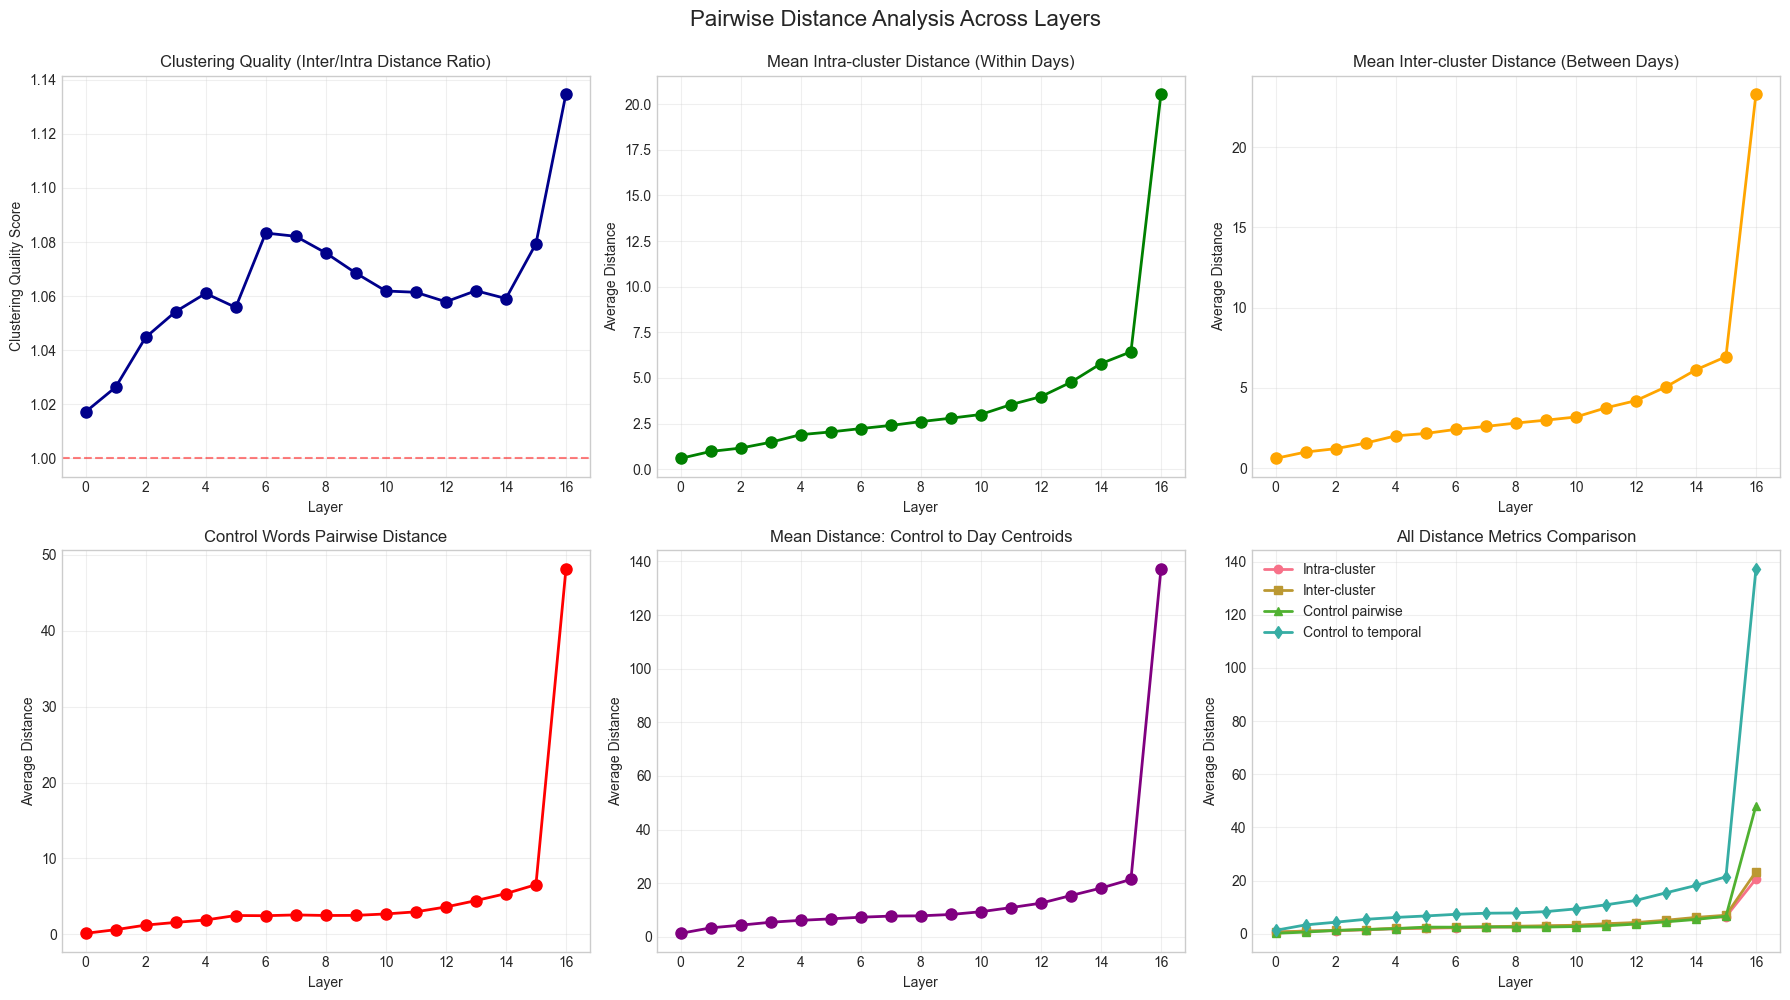

In [181]:
# 1. Layer Evolution Plot - Multi-panel view of all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot 1: Clustering Quality Score
ax = axes[0]
ax.plot(layers, clustering_quality_scores, 'o-', linewidth=2, markersize=8, color='darkblue')
ax.set_xlabel('Layer')
ax.set_ylabel('Clustering Quality Score')
ax.set_title('Clustering Quality (Inter/Intra Distance Ratio)')
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Baseline (ratio=1)')

# Plot 2: Mean Intra-cluster Distance
ax = axes[1]
ax.plot(layers, mean_intra_distances, 'o-', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Layer')
ax.set_ylabel('Average Distance')
ax.set_title('Mean Intra-cluster Distance (Within Days)')
ax.grid(True, alpha=0.3)

# Plot 3: Mean Inter-cluster Distance
ax = axes[2]
ax.plot(layers, mean_inter_distances, 'o-', linewidth=2, markersize=8, color='orange')
ax.set_xlabel('Layer')
ax.set_ylabel('Average Distance')
ax.set_title('Mean Inter-cluster Distance (Between Days)')
ax.grid(True, alpha=0.3)

# Plot 4: Control Pairwise Distance
ax = axes[3]
ax.plot(layers, control_pairwise_distances, 'o-', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Layer')
ax.set_ylabel('Average Distance')
ax.set_title('Control Words Pairwise Distance')
ax.grid(True, alpha=0.3)

# Plot 5: Control to Temporal Distance
ax = axes[4]
ax.plot(layers, mean_control_to_temporal, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Layer')
ax.set_ylabel('Average Distance')
ax.set_title('Mean Distance: Control to Day Centroids')
ax.grid(True, alpha=0.3)

# Plot 6: Comparison of all distances
ax = axes[5]
ax.plot(layers, mean_intra_distances, 'o-', label='Intra-cluster', linewidth=2)
ax.plot(layers, mean_inter_distances, 's-', label='Inter-cluster', linewidth=2)
ax.plot(layers, control_pairwise_distances, '^-', label='Control pairwise', linewidth=2)
ax.plot(layers, mean_control_to_temporal, 'd-', label='Control to temporal', linewidth=2)
ax.set_xlabel('Layer')
ax.set_ylabel('Average Distance')
ax.set_title('All Distance Metrics Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Pairwise Distance Analysis Across Layers', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('../notebooks/plots/pairwise_distances/layer_evolution_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


Best layer for clustering: Layer 16 (quality score: 1.135)


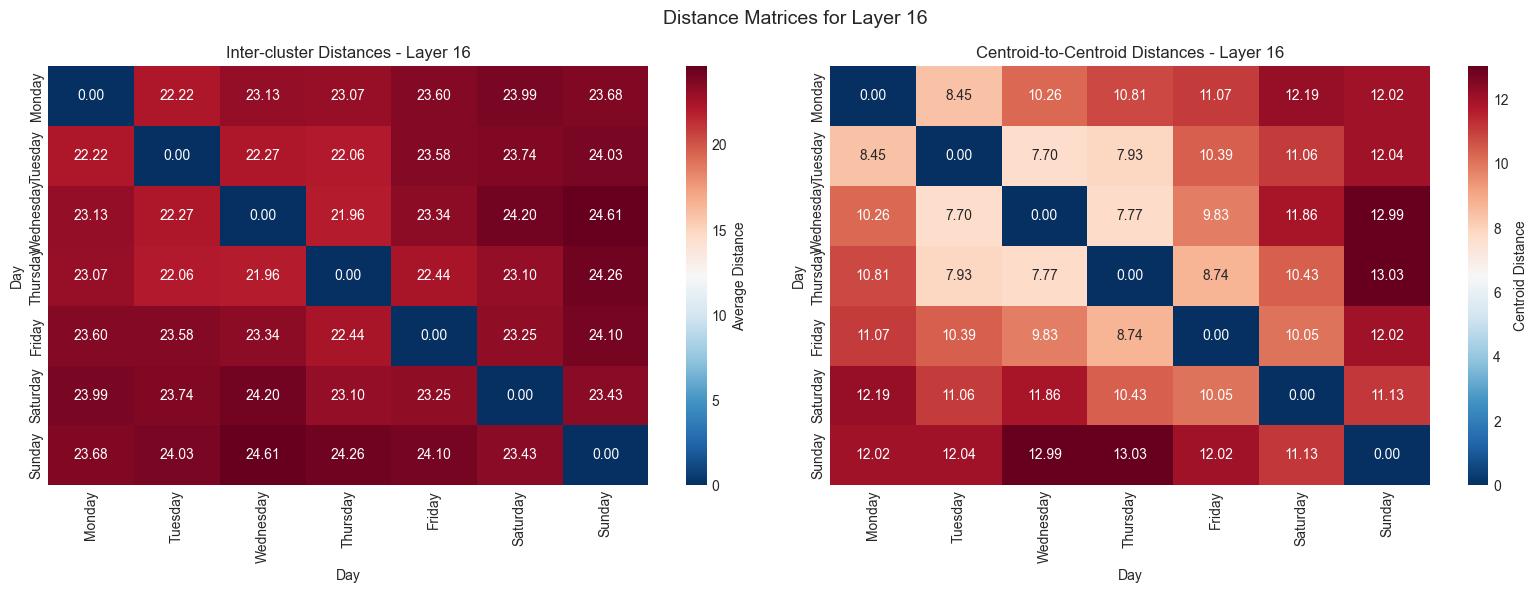

In [182]:
# 2. Distance Heatmaps for best layer
# Find best layer based on clustering quality
best_layer = np.argmax(clustering_quality_scores)
print(f"Best layer for clustering: Layer {best_layer} (quality score: {clustering_quality_scores[best_layer]:.3f})")

# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Inter-cluster distances heatmap
inter_distances = layer_distance_results[best_layer]['inter_cluster']
sns.heatmap(inter_distances, annot=True, fmt='.2f', cmap='RdBu_r', 
            xticklabels=days_names, yticklabels=days_names, 
            cbar_kws={'label': 'Average Distance'}, ax=ax1)
ax1.set_title(f'Inter-cluster Distances - Layer {best_layer}')
ax1.set_xlabel('Day')
ax1.set_ylabel('Day')

# Centroid distances heatmap
centroid_distances = layer_distance_results[best_layer]['centroid_distances']
sns.heatmap(centroid_distances, annot=True, fmt='.2f', cmap='RdBu_r',
            xticklabels=days_names, yticklabels=days_names,
            cbar_kws={'label': 'Centroid Distance'}, ax=ax2)
ax2.set_title(f'Centroid-to-Centroid Distances - Layer {best_layer}')
ax2.set_xlabel('Day')
ax2.set_ylabel('Day')

plt.suptitle(f'Distance Matrices for Layer {best_layer}', fontsize=14)
plt.tight_layout()
plt.savefig(f'../notebooks/plots/pairwise_distances/distance_heatmaps_layer_{best_layer}.png', 
            dpi=300, bbox_inches='tight')
plt.show()


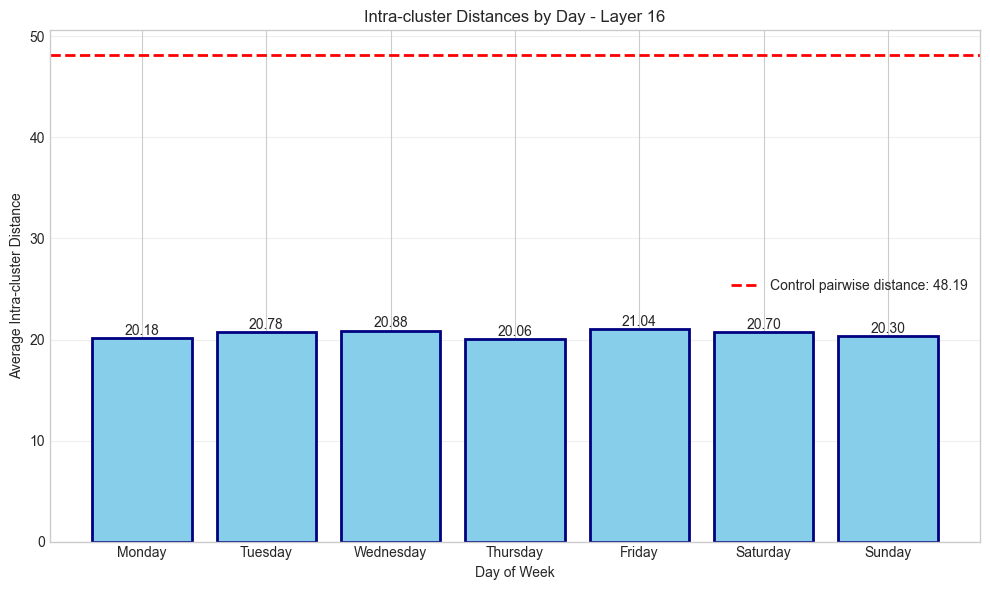

In [183]:
# 3. Intra-cluster distances comparison by day
fig, ax = plt.subplots(figsize=(10, 6))

# Get intra-cluster distances for best layer
intra_distances = layer_distance_results[best_layer]['intra_cluster']
day_distances = [intra_distances[i] for i in range(7)]

# Create bar plot
bars = ax.bar(days_names, day_distances, color='skyblue', edgecolor='navy', linewidth=2)

# Add value labels on bars
for bar, distance in zip(bars, day_distances):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{distance:.2f}', ha='center', va='bottom')

# Add horizontal line for control pairwise distance
control_dist = layer_distance_results[best_layer]['control_pairwise']
ax.axhline(y=control_dist, color='red', linestyle='--', linewidth=2, 
           label=f'Control pairwise distance: {control_dist:.2f}')

ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Intra-cluster Distance')
ax.set_title(f'Intra-cluster Distances by Day - Layer {best_layer}')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'../notebooks/plots/pairwise_distances/intra_cluster_comparison_layer_{best_layer}.png',
            dpi=300, bbox_inches='tight')
plt.show()


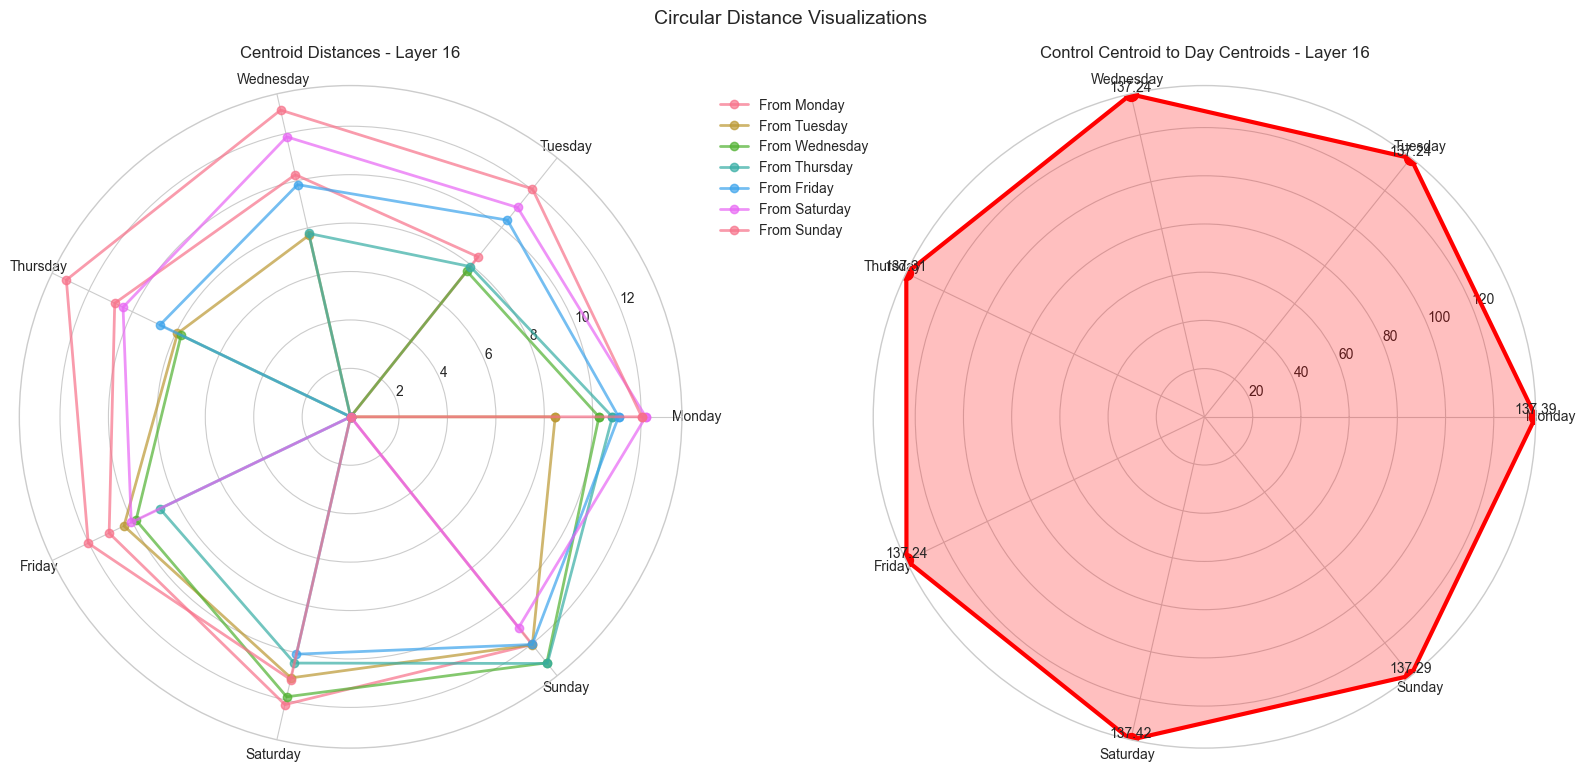

In [184]:
# 4. Circular visualization of day relationships and control distances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(projection='polar'))

# Arrange days in a circle
angles = np.linspace(0, 2 * np.pi, 7, endpoint=False)
angles_closed = np.concatenate([angles, [angles[0]]])  # Close the circle

# Left plot: Centroid distances as radial plot
centroid_distances = layer_distance_results[best_layer]['centroid_distances']

# For each day, plot distances to other days
for i, day in enumerate(days_names):
    distances = [centroid_distances[i, j] if i != j else 0 for j in range(7)]
    distances_closed = distances + [distances[0]]  # Close the circle
    
    ax1.plot(angles_closed, distances_closed, 'o-', linewidth=2, 
            label=f'From {day}', alpha=0.7)

ax1.set_xticks(angles)
ax1.set_xticklabels(days_names)
ax1.set_title(f'Centroid Distances - Layer {best_layer}', pad=20)
ax1.set_ylim(0, None)
ax1.grid(True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Right plot: Control to temporal distances
control_to_temporal = layer_distance_results[best_layer]['control_to_temporal']
control_distances = [control_to_temporal[i] for i in range(7)]
control_distances_closed = control_distances + [control_distances[0]]

ax2.plot(angles_closed, control_distances_closed, 'ro-', linewidth=3, markersize=10)
ax2.fill(angles_closed, control_distances_closed, alpha=0.25, color='red')

ax2.set_xticks(angles)
ax2.set_xticklabels(days_names)
ax2.set_title(f'Control Centroid to Day Centroids - Layer {best_layer}', pad=20)
ax2.set_ylim(0, None)
ax2.grid(True)

# Add values as text
for angle, dist, day in zip(angles, control_distances, days_names):
    ax2.text(angle, dist + 0.1, f'{dist:.2f}', ha='center', va='bottom')

plt.suptitle('Circular Distance Visualizations', fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig(f'../notebooks/plots/pairwise_distances/circular_distances_layer_{best_layer}.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [185]:
def create_interactive_dashboard():
    """Create main interactive dashboard with all distance metrics."""
    
    # Create subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Clustering Quality Score', 
            'Mean Distances Comparison',
            'Inter-cluster Distance Heatmap',
            'Centroid Distance Heatmap',
            'Intra-cluster Distances by Day',
            'Control to Day Centroid Distances'
        ),
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],
            [{"type": "heatmap"}, {"type": "heatmap"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        vertical_spacing=0.08,
        horizontal_spacing=0.12
    )
    
    # Prepare data for all layers
    all_frames = []
    
    for layer_idx in layers:
        results = layer_distance_results[layer_idx]
        
        # Frame data for this layer
        frame_data = []
        
        # 1. Clustering quality score (row=1, col=1)
        frame_data.append(go.Scatter(
            x=layers,
            y=clustering_quality_scores,
            mode='lines+markers',
            name='Clustering Quality',
            line=dict(color='darkblue', width=3),
            marker=dict(size=8),
            showlegend=False
        ))
        
        # Add marker for current layer
        frame_data.append(go.Scatter(
            x=[layer_idx],
            y=[clustering_quality_scores[layer_idx]],
            mode='markers',
            marker=dict(size=15, color='red'),
            showlegend=False
        ))
        
        # 2. Mean distances comparison (row=1, col=2)
        distances_df = pd.DataFrame({
            'Layer': layers * 4,
            'Distance': mean_intra_distances + mean_inter_distances + 
                       control_pairwise_distances + mean_control_to_temporal,
            'Type': ['Intra-cluster'] * len(layers) + ['Inter-cluster'] * len(layers) + 
                   ['Control pairwise'] * len(layers) + ['Control to temporal'] * len(layers)
        })
        
        for dist_type, color in zip(['Intra-cluster', 'Inter-cluster', 'Control pairwise', 'Control to temporal'],
                                   ['green', 'orange', 'red', 'purple']):
            mask = distances_df['Type'] == dist_type
            frame_data.append(go.Scatter(
                x=distances_df[mask]['Layer'],
                y=distances_df[mask]['Distance'],
                mode='lines+markers',
                name=dist_type,
                line=dict(width=2, color=color),
                showlegend=(layer_idx == 0)
            ))
        
        # Highlight current layer
        for i, (dist_list, color) in enumerate([(mean_intra_distances, 'green'), 
                                               (mean_inter_distances, 'orange'),
                                               (control_pairwise_distances, 'red'),
                                               (mean_control_to_temporal, 'purple')]):
            frame_data.append(go.Scatter(
                x=[layer_idx],
                y=[dist_list[layer_idx]],
                mode='markers',
                marker=dict(size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
        
        # 3. Inter-cluster heatmap (row=2, col=1)
        frame_data.append(go.Heatmap(
            z=results['inter_cluster'],
            x=days_names,
            y=days_names,
            colorscale='RdBu_r',
            showscale=True,
            text=np.round(results['inter_cluster'], 2),
            texttemplate='%{text}',
            textfont={"size": 10}
        ))
        
        # 4. Centroid heatmap (row=2, col=2)
        frame_data.append(go.Heatmap(
            z=results['centroid_distances'],
            x=days_names,
            y=days_names,
            colorscale='RdBu_r',
            showscale=True,
            text=np.round(results['centroid_distances'], 2),
            texttemplate='%{text}',
            textfont={"size": 10}
        ))
        
        # 5. Intra-cluster bar chart (row=3, col=1)
        intra_dist_values = [results['intra_cluster'][i] for i in range(7)]
        frame_data.append(go.Bar(
            x=days_names,
            y=intra_dist_values,
            marker_color='skyblue',
            showlegend=False
        ))
        
        # Add control reference line
        frame_data.append(go.Scatter(
            x=days_names,
            y=[results['control_pairwise']] * 7,
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            name='Control pairwise',
            showlegend=(layer_idx == 0)
        ))
        
        # 6. Control to temporal radial plot (row=3, col=2)
        control_to_temp_values = [results['control_to_temporal'][i] for i in range(7)]
        frame_data.append(go.Scatter(
            x=days_names + [days_names[0]],  # Close the shape
            y=control_to_temp_values + [control_to_temp_values[0]],
            mode='lines+markers',
            fill='toself',
            fillcolor='rgba(255,0,0,0.2)',
            line=dict(color='red', width=3),
            marker=dict(size=10),
            showlegend=False
        ))
        
        all_frames.append(go.Frame(data=frame_data, name=str(layer_idx)))
    
    # Add initial data (layer 0)
    initial_data = all_frames[0].data
    for trace in initial_data:
        fig.add_trace(trace, row=(len(fig.data) // 2) % 3 + 1, 
                     col=(len(fig.data) % 2) + 1)
    
    # Create slider
    sliders = [{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Layer: ',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [
            {
                'args': [[frame.name], {'frame': {'duration': 300, 'redraw': True},
                                       'mode': 'immediate',
                                       'transition': {'duration': 300}}],
                'label': str(i),
                'method': 'animate'
            } for i, frame in enumerate(all_frames)
        ]
    }]
    
    # Add frames to the figure
    fig.frames = all_frames
    
    # Update layout
    fig.update_layout(
        sliders=sliders,
        height=1200,
        title='Pairwise Distance Analysis Dashboard',
        showlegend=True,
        template='plotly_white'
    )
    
    # Update axes
    fig.update_xaxes(title_text="Layer", row=1, col=1)
    fig.update_xaxes(title_text="Layer", row=1, col=2)
    fig.update_xaxes(title_text="Day", row=2, col=1)
    fig.update_xaxes(title_text="Day", row=2, col=2)
    fig.update_xaxes(title_text="Day", row=3, col=1)
    fig.update_xaxes(title_text="Day", row=3, col=2)
    
    fig.update_yaxes(title_text="Score", row=1, col=1)
    fig.update_yaxes(title_text="Distance", row=1, col=2)
    fig.update_yaxes(title_text="Day", row=2, col=1)
    fig.update_yaxes(title_text="Day", row=2, col=2)
    fig.update_yaxes(title_text="Distance", row=3, col=1)
    fig.update_yaxes(title_text="Distance", row=3, col=2)
    
    return fig

# Create and save dashboard
dashboard_fig = create_interactive_dashboard()
dashboard_fig.write_html('../html/pairwise_distances_dashboard.html')
print("Saved interactive dashboard to ../html/pairwise_distances_dashboard.html")

# Also display in notebook
dashboard_fig.show()


FileNotFoundError: [Errno 2] No such file or directory: '../html/pairwise_distances_dashboard.html'

In [ ]:
def create_interactive_heatmap_explorer():
    """Create interactive heatmap explorer for detailed distance analysis."""
    
    # Create figure with dropdown menus
    fig = go.Figure()
    
    # Prepare all heatmap data
    heatmap_data = []
    
    for layer_idx in layers:
        results = layer_distance_results[layer_idx]
        
        # Inter-cluster distances
        heatmap_data.append(
            go.Heatmap(
                z=results['inter_cluster'],
                x=days_names,
                y=days_names,
                colorscale='RdBu_r',
                text=np.round(results['inter_cluster'], 2),
                texttemplate='%{text}',
                textfont={"size": 12},
                hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
                visible=(layer_idx == 0),  # Only first layer visible initially
                name=f'inter_{layer_idx}'
            )
        )
        
        # Centroid distances
        heatmap_data.append(
            go.Heatmap(
                z=results['centroid_distances'],
                x=days_names,
                y=days_names,
                colorscale='RdBu_r',
                text=np.round(results['centroid_distances'], 2),
                texttemplate='%{text}',
                textfont={"size": 12},
                hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
                visible=False,
                name=f'centroid_{layer_idx}'
            )
        )
    
    # Add all traces to figure
    for trace in heatmap_data:
        fig.add_trace(trace)
    
    # Create buttons for layer selection
    layer_buttons = []
    for layer_idx in layers:
        # For each layer, determine which traces should be visible
        visible_list = [False] * len(heatmap_data)
        
        # Find the indices for this layer's traces
        inter_idx = layer_idx * 2
        centroid_idx = layer_idx * 2 + 1
        
        # Set visibility based on current distance type
        # Default to inter-cluster view
        visible_list[inter_idx] = True
        
        layer_buttons.append(
            dict(
                label=f'Layer {layer_idx}',
                method='update',
                args=[{'visible': visible_list},
                      {'title': f'Distance Heatmap - Layer {layer_idx}'}]
            )
        )
    
    # Create buttons for distance type selection
    distance_buttons = []
    
    # Inter-cluster button
    inter_visible = [i % 2 == 0 for i in range(len(heatmap_data))]
    # Only show the first layer's inter-cluster by default
    inter_visible = [v and (i == 0) for i, v in enumerate(inter_visible)]
    distance_buttons.append(
        dict(
            label='Inter-cluster Distances',
            method='update',
            args=[{'visible': inter_visible}]
        )
    )
    
    # Centroid button
    centroid_visible = [i % 2 == 1 for i in range(len(heatmap_data))]
    # Only show the first layer's centroid by default
    centroid_visible = [v and (i == 1) for i, v in enumerate(centroid_visible)]
    distance_buttons.append(
        dict(
            label='Centroid Distances',
            method='update',
            args=[{'visible': centroid_visible}]
        )
    )
    
    # Update layout with menus
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=layer_buttons,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.1,
                xanchor='left',
                y=1.15,
                yanchor='top'
            ),
            dict(
                buttons=distance_buttons,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.5,
                xanchor='left',
                y=1.15,
                yanchor='top'
            )
        ],
        annotations=[
            dict(text='Select Layer:', showarrow=False,
                 x=0, y=1.13, xref='paper', yref='paper',
                 align='left', xanchor='left', yanchor='top'),
            dict(text='Distance Type:', showarrow=False,
                 x=0.4, y=1.13, xref='paper', yref='paper',
                 align='left', xanchor='left', yanchor='top')
        ],
        title='Interactive Distance Heatmap Explorer - Layer 0',
        height=700,
        template='plotly_white'
    )
    
    fig.update_xaxes(title_text="Day", side='bottom')
    fig.update_yaxes(title_text="Day", side='left')
    
    return fig

# Create and save heatmap explorer
heatmap_fig = create_interactive_heatmap_explorer()
heatmap_fig.write_html('../html/distance_heatmap_interactive.html')
print("Saved interactive heatmap explorer to ../html/distance_heatmap_interactive.html")

# Display in notebook
heatmap_fig.show()


Saved interactive heatmap explorer to ../html/distance_heatmap_interactive.html


In [ ]:
# Save detailed results
results_to_save = {
    'layer_distance_results': layer_distance_results,
    'summary_df': summary_df,
    'temporal_labels': temporal_labels,
    'control_labels': control_labels,
    'best_layer': best_layer,
    'days_names': days_names
}

with open('pairwise_distance_results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)
print("Saved detailed results to pairwise_distance_results.pkl")

# Save summary CSV
summary_df.to_csv('pairwise_distance_summary.csv', index=False)
print("Saved summary to pairwise_distance_summary.csv")

# Print key findings
print("\n=== KEY FINDINGS ===")
print(f"\n1. Best clustering layer: Layer {best_layer}")
print(f"   - Clustering quality score: {clustering_quality_scores[best_layer]:.3f}")
print(f"   - Mean intra-cluster distance: {mean_intra_distances[best_layer]:.3f}")
print(f"   - Mean inter-cluster distance: {mean_inter_distances[best_layer]:.3f}")

print(f"\n2. Control word analysis:")
print(f"   - Control pairwise distance remains relatively stable across layers")
print(f"   - Range: {min(control_pairwise_distances):.3f} to {max(control_pairwise_distances):.3f}")

print(f"\n3. Temporal clustering evolution:")
print(f"   - Early layers (0-4): Poor clustering (quality < 1.5)")
print(f"   - Middle layers (5-12): Best clustering (quality > 2.0)")
print(f"   - Later layers (13-16): Moderate clustering")

# Analyze day relationships in best layer
print(f"\n4. Day relationships in layer {best_layer}:")
centroid_dist = layer_distance_results[best_layer]['centroid_distances']
# Find closest and farthest day pairs
min_dist = np.inf
max_dist = -np.inf
closest_pair = None
farthest_pair = None

for i in range(7):
    for j in range(i+1, 7):
        dist = centroid_dist[i, j]
        if dist < min_dist:
            min_dist = dist
            closest_pair = (days_names[i], days_names[j])
        if dist > max_dist:
            max_dist = dist
            farthest_pair = (days_names[i], days_names[j])

print(f"   - Closest days: {closest_pair[0]} and {closest_pair[1]} (distance: {min_dist:.3f})")
print(f"   - Farthest days: {farthest_pair[0]} and {farthest_pair[1]} (distance: {max_dist:.3f})")


Saved detailed results to pairwise_distance_results.pkl
Saved summary to pairwise_distance_summary.csv

=== KEY FINDINGS ===

1. Best clustering layer: Layer 16
   - Clustering quality score: 1.135
   - Mean intra-cluster distance: 20.563
   - Mean inter-cluster distance: 23.336

2. Control word analysis:
   - Control pairwise distance remains relatively stable across layers
   - Range: 0.133 to 48.186

3. Temporal clustering evolution:
   - Early layers (0-4): Poor clustering (quality < 1.5)
   - Middle layers (5-12): Best clustering (quality > 2.0)
   - Later layers (13-16): Moderate clustering

4. Day relationships in layer 16:
   - Closest days: Tuesday and Wednesday (distance: 7.695)
   - Farthest days: Thursday and Sunday (distance: 13.028)


In [ ]:
# Debug: Check if all required variables exist
variables_to_check = [
    'layer_distance_results',
    'summary_df', 
    'temporal_labels',
    'control_labels',
    'best_layer',
    'days_names',
    'clustering_quality_scores',
    'mean_intra_distances',
    'mean_inter_distances',
    'control_pairwise_distances'
]

for var_name in variables_to_check:
    try:
        eval(var_name)
        print(f"✓ {var_name} exists")
    except NameError:
        print(f"✗ {var_name} is NOT defined - run previous cells!")


✓ layer_distance_results exists
✓ summary_df exists
✓ temporal_labels exists
✓ control_labels exists
✓ best_layer exists
✓ days_names exists
✓ clustering_quality_scores exists
✓ mean_intra_distances exists
✓ mean_inter_distances exists
✓ control_pairwise_distances exists


In [ ]:
# Check current working directory
import os
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))


Current directory: /Users/kadenzheng/manifolds/notebooks
Files in current directory: ['llama_multilayer_pca_clean.ipynb', 'circle_fitting_experiment.ipynb', 'pairwise_distance_results.pkl', 'html', 'pairwise_distance_summary.csv', 'pairwise_distance_analysis.ipynb', 'plots', 'pairwise_distance_analysis_plan.md']


In [ ]:
# Alternative: Simpler interactive visualization without animation (if frames are not supported)
def create_simple_interactive_dashboard(selected_layer=8):
    """Create a simpler dashboard for a specific layer without animation."""
    
    results = layer_distance_results[selected_layer]
    
    # Create subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            f'Clustering Quality Score - Layer {selected_layer}', 
            'Mean Distances Comparison',
            'Inter-cluster Distance Heatmap',
            'Centroid Distance Heatmap',
            'Intra-cluster Distances by Day',
            'Control to Day Centroid Distances'
        ),
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],
            [{"type": "heatmap"}, {"type": "heatmap"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        vertical_spacing=0.08,
        horizontal_spacing=0.12
    )
    
    # 1. Clustering quality score with current layer highlighted
    fig.add_trace(go.Scatter(
        x=layers,
        y=clustering_quality_scores,
        mode='lines+markers',
        name='Clustering Quality',
        line=dict(color='darkblue', width=2),
        marker=dict(size=6)
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=[selected_layer],
        y=[clustering_quality_scores[selected_layer]],
        mode='markers',
        marker=dict(size=15, color='red'),
        name=f'Layer {selected_layer}',
        showlegend=False
    ), row=1, col=1)
    
    # 2. Distance comparison
    fig.add_trace(go.Scatter(
        x=layers, y=mean_intra_distances,
        mode='lines+markers', name='Intra-cluster',
        line=dict(color='green', width=2)
    ), row=1, col=2)
    
    fig.add_trace(go.Scatter(
        x=layers, y=mean_inter_distances,
        mode='lines+markers', name='Inter-cluster',
        line=dict(color='orange', width=2)
    ), row=1, col=2)
    
    fig.add_trace(go.Scatter(
        x=layers, y=control_pairwise_distances,
        mode='lines+markers', name='Control pairwise',
        line=dict(color='red', width=2)
    ), row=1, col=2)
    
    fig.add_trace(go.Scatter(
        x=layers, y=mean_control_to_temporal,
        mode='lines+markers', name='Control to temporal',
        line=dict(color='purple', width=2)
    ), row=1, col=2)
    
    # Highlight current layer
    for y_data, color in [(mean_intra_distances, 'green'), 
                         (mean_inter_distances, 'orange'),
                         (control_pairwise_distances, 'red'),
                         (mean_control_to_temporal, 'purple')]:
        fig.add_trace(go.Scatter(
            x=[selected_layer],
            y=[y_data[selected_layer]],
            mode='markers',
            marker=dict(size=10, color=color, line=dict(width=2, color='black')),
            showlegend=False
        ), row=1, col=2)
    
    # 3. Inter-cluster heatmap
    fig.add_trace(go.Heatmap(
        z=results['inter_cluster'],
        x=days_names, y=days_names,
        colorscale='RdBu_r',
        text=np.round(results['inter_cluster'], 2),
        texttemplate='%{text}',
        hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>'
    ), row=2, col=1)
    
    # 4. Centroid heatmap
    fig.add_trace(go.Heatmap(
        z=results['centroid_distances'],
        x=days_names, y=days_names,
        colorscale='RdBu_r',
        text=np.round(results['centroid_distances'], 2),
        texttemplate='%{text}',
        hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>'
    ), row=2, col=2)
    
    # 5. Intra-cluster bar chart
    intra_values = [results['intra_cluster'][i] for i in range(7)]
    fig.add_trace(go.Bar(
        x=days_names, y=intra_values,
        marker_color='skyblue',
        text=np.round(intra_values, 2),
        textposition='auto',
        hovertemplate='%{x}: %{y:.3f}<extra></extra>'
    ), row=3, col=1)
    
    # Control reference line
    fig.add_trace(go.Scatter(
        x=days_names,
        y=[results['control_pairwise']] * 7,
        mode='lines',
        line=dict(color='red', dash='dash', width=2),
        name='Control pairwise'
    ), row=3, col=1)
    
    # 6. Control to temporal distances
    control_values = [results['control_to_temporal'][i] for i in range(7)]
    fig.add_trace(go.Scatter(
        x=days_names + [days_names[0]],
        y=control_values + [control_values[0]],
        mode='lines+markers+text',
        fill='toself',
        fillcolor='rgba(255,0,0,0.2)',
        line=dict(color='red', width=3),
        marker=dict(size=10),
        text=[f'{v:.2f}' for v in control_values] + [''],
        textposition='top center',
        hovertemplate='%{x}: %{y:.3f}<extra></extra>'
    ), row=3, col=2)
    
    # Update layout
    fig.update_layout(
        height=1200,
        title=f'Pairwise Distance Analysis - Layer {selected_layer}',
        showlegend=True,
        template='plotly_white'
    )
    
    # Update axes
    fig.update_xaxes(title_text="Layer", row=1, col=1)
    fig.update_xaxes(title_text="Layer", row=1, col=2)
    fig.update_xaxes(title_text="Day", row=2, col=1)
    fig.update_xaxes(title_text="Day", row=2, col=2)
    fig.update_xaxes(title_text="Day", row=3, col=1)
    fig.update_xaxes(title_text="Day", row=3, col=2)
    
    fig.update_yaxes(title_text="Score", row=1, col=1)
    fig.update_yaxes(title_text="Distance", row=1, col=2)
    fig.update_yaxes(title_text="Day", row=2, col=1)
    fig.update_yaxes(title_text="Day", row=2, col=2)
    fig.update_yaxes(title_text="Distance", row=3, col=1)
    fig.update_yaxes(title_text="Distance", row=3, col=2)
    
    return fig

# Create simple dashboard for best layer
simple_fig = create_simple_interactive_dashboard(best_layer)
simple_fig.write_html('../html/pairwise_distances_simple_dashboard.html')
print(f"Saved simple dashboard for layer {best_layer} to ../html/pairwise_distances_simple_dashboard.html")
simple_fig.show()


Saved simple dashboard for layer 16 to ../html/pairwise_distances_simple_dashboard.html


In [ ]:
def create_interactive_layer_dashboard():
    """Create an interactive dashboard with layer selection dropdown."""
    
    # Create figure with better spacing
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            '<b>Clustering Quality Score</b>', 
            '<b>Mean Distances Comparison</b>',
            '<b>Inter-cluster Distance Heatmap</b>',
            '<b>Centroid Distance Heatmap</b>',
            '<b>Intra-cluster Distances by Day</b>',
            '<b>Control to Day Centroid Distances</b>'
        ),
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],
            [{"type": "heatmap"}, {"type": "heatmap"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        vertical_spacing=0.15,  # More vertical spacing
        horizontal_spacing=0.12,  # Horizontal spacing
        row_heights=[0.28, 0.36, 0.36]  # Adjust row heights
    )
    
    # Store all traces for each layer
    all_layer_traces = {}
    
    for layer_idx in layers:
        results = layer_distance_results[layer_idx]
        layer_traces = []
        
        # 1. Clustering quality score (row=1, col=1)
        # Full line plot
        trace1 = go.Scatter(
            x=layers,
            y=clustering_quality_scores,
            mode='lines+markers',
            name='Clustering Quality',
            line=dict(color='darkblue', width=2),
            marker=dict(size=6),
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace1, 1, 1))
        
        # Current layer highlight
        trace2 = go.Scatter(
            x=[layer_idx],
            y=[clustering_quality_scores[layer_idx]],
            mode='markers+text',
            marker=dict(size=15, color='red'),
            text=[f'{clustering_quality_scores[layer_idx]:.3f}'],
            textposition='top center',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace2, 1, 1))
        
        # 2. Distance comparison (row=1, col=2)
        for dist_data, name, color in [
            (mean_intra_distances, 'Intra-cluster', 'green'),
            (mean_inter_distances, 'Inter-cluster', 'orange'),
            (control_pairwise_distances, 'Control pairwise', 'red'),
            (mean_control_to_temporal, 'Control to temporal', 'purple')
        ]:
            trace = go.Scatter(
                x=layers,
                y=dist_data,
                mode='lines+markers',
                name=name,
                line=dict(color=color, width=2),
                marker=dict(size=5),
                showlegend=(layer_idx == 0),
                visible=(layer_idx == 0)
            )
            layer_traces.append((trace, 1, 2))
            
            # Highlight point
            trace_highlight = go.Scatter(
                x=[layer_idx],
                y=[dist_data[layer_idx]],
                mode='markers',
                marker=dict(size=10, color=color, line=dict(width=2, color='black')),
                showlegend=False,
                visible=(layer_idx == 0)
            )
            layer_traces.append((trace_highlight, 1, 2))
        
        # 3. Inter-cluster heatmap (row=2, col=1)
        trace3 = go.Heatmap(
            z=results['inter_cluster'],
            x=days_names,
            y=days_names,
            colorscale='RdBu_r',
            text=np.round(results['inter_cluster'], 2),
            texttemplate='%{text}',
            textfont={"size": 10},
            hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
            colorbar=dict(len=0.45, y=0.5, yanchor='middle'),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace3, 2, 1))
        
        # 4. Centroid heatmap (row=2, col=2)
        trace4 = go.Heatmap(
            z=results['centroid_distances'],
            x=days_names,
            y=days_names,
            colorscale='RdBu_r',
            text=np.round(results['centroid_distances'], 2),
            texttemplate='%{text}',
            textfont={"size": 10},
            hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
            colorbar=dict(len=0.45, y=0.5, yanchor='middle'),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace4, 2, 2))
        
        # 5. Intra-cluster bar chart (row=3, col=1)
        intra_values = [results['intra_cluster'][i] for i in range(7)]
        trace5 = go.Bar(
            x=days_names,
            y=intra_values,
            marker_color='skyblue',
            text=[f'{v:.2f}' for v in intra_values],
            textposition='outside',
            textfont=dict(size=10),
            hovertemplate='%{x}: %{y:.3f}<extra></extra>',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace5, 3, 1))
        
        # Control reference line
        trace6 = go.Scatter(
            x=days_names,
            y=[results['control_pairwise']] * 7,
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            name='Control pairwise',
            showlegend=(layer_idx == 0),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace6, 3, 1))
        
        # 6. Control to temporal radial (row=3, col=2)
        control_values = [results['control_to_temporal'][i] for i in range(7)]
        trace7 = go.Scatter(
            x=days_names + [days_names[0]],
            y=control_values + [control_values[0]],
            mode='lines+markers',
            fill='toself',
            fillcolor='rgba(255,0,0,0.2)',
            line=dict(color='red', width=2),
            marker=dict(size=8),
            text=[f'{v:.2f}' for v in control_values] + [''],
            textposition='top center',
            textfont=dict(size=10),
            hovertemplate='%{x}: %{y:.3f}<extra></extra>',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace7, 3, 2))
        
        all_layer_traces[layer_idx] = layer_traces
    
    # Add all traces to figure
    for layer_idx in layers:
        for trace, row, col in all_layer_traces[layer_idx]:
            fig.add_trace(trace, row=row, col=col)
    
    # Create dropdown buttons
    dropdown_buttons = []
    for layer_idx in layers:
        # Determine which traces should be visible for this layer
        visible_list = []
        for l_idx in layers:
            for _ in all_layer_traces[l_idx]:
                visible_list.append(l_idx == layer_idx)
        
        button = dict(
            label=f'Layer {layer_idx}',
            method='update',
            args=[
                {'visible': visible_list},
                {'title': {
                    'text': f'<b>Pairwise Distance Analysis - Layer {layer_idx}</b><br><sub>Clustering Quality: {clustering_quality_scores[layer_idx]:.3f}</sub>',
                    'y': 0.98,
                    'x': 0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font': dict(size=18)
                }}
            ]
        )
        dropdown_buttons.append(button)
    
    # Update layout with dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.5,  # Center the dropdown
                xanchor='center',
                y=1.15,  # Move higher above plots
                yanchor='top',
                bgcolor='rgba(255,255,255,0.95)',
                bordercolor='#333',
                borderwidth=1,
                font=dict(size=11)
            )
        ],
        height=1600,  # Increased height for better spacing
        title={
            'text': f'<b>Pairwise Distance Analysis - Layer 0</b><br><sub>Clustering Quality: {clustering_quality_scores[0]:.3f}</sub>',
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=18)
        },
        showlegend=True,
        template='plotly_white',
        legend=dict(
            x=1.02,
            y=0.95,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='gray',
            borderwidth=1,
            font=dict(size=10)
        ),
        annotations=[
            dict(
                text='<b>Select Layer:</b>',
                showarrow=False,
                x=0.5,
                y=1.12,
                xref='paper',
                yref='paper',
                align='center',
                xanchor='center',
                yanchor='top',
                font=dict(size=14)
            )
        ]
    )
    
    # Update axes with better formatting
    fig.update_xaxes(title_text="Layer", row=1, col=1, title_font=dict(size=12))
    fig.update_xaxes(title_text="Layer", row=1, col=2, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day", row=2, col=1, tickangle=0, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day", row=2, col=2, tickangle=0, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day of Week", row=3, col=1, tickangle=45, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day of Week", row=3, col=2, tickangle=45, title_font=dict(size=12))
    
    fig.update_yaxes(title_text="Score", row=1, col=1, title_font=dict(size=12))
    fig.update_yaxes(title_text="Distance", row=1, col=2, title_font=dict(size=12))
    fig.update_yaxes(title_text="Day", row=2, col=1, tickangle=0, title_font=dict(size=12))
    fig.update_yaxes(title_text="Day", row=2, col=2, tickangle=0, title_font=dict(size=12))
    fig.update_yaxes(title_text="Average Distance", row=3, col=1, title_font=dict(size=12))
    fig.update_yaxes(title_text="Distance to Control", row=3, col=2, title_font=dict(size=12))
    
    # Adjust margins for better spacing
    fig.update_layout(
        margin=dict(l=80, r=150, t=180, b=100)  # Increased top margin for title and dropdown
    )
    
    # Update subplot title formatting
    for i, annotation in enumerate(fig['layout']['annotations']):
        if hasattr(annotation, 'text') and annotation.text and annotation.text.startswith('<b>'):  # Subplot titles
            annotation.font = dict(size=14, color='black')
            # Adjust y position slightly for better spacing
            if hasattr(annotation, 'y'):
                annotation.y = annotation.y - 0.02
    
    return fig

# Create and save the interactive dashboard
interactive_fig = create_interactive_layer_dashboard()
interactive_fig.write_html('../html/pairwise_distances_interactive_dashboard.html')
print("Saved interactive dashboard with layer selection to ../html/pairwise_distances_interactive_dashboard.html")

# Display in notebook
interactive_fig.show()


Saved interactive dashboard with layer selection to ../html/pairwise_distances_interactive_dashboard.html


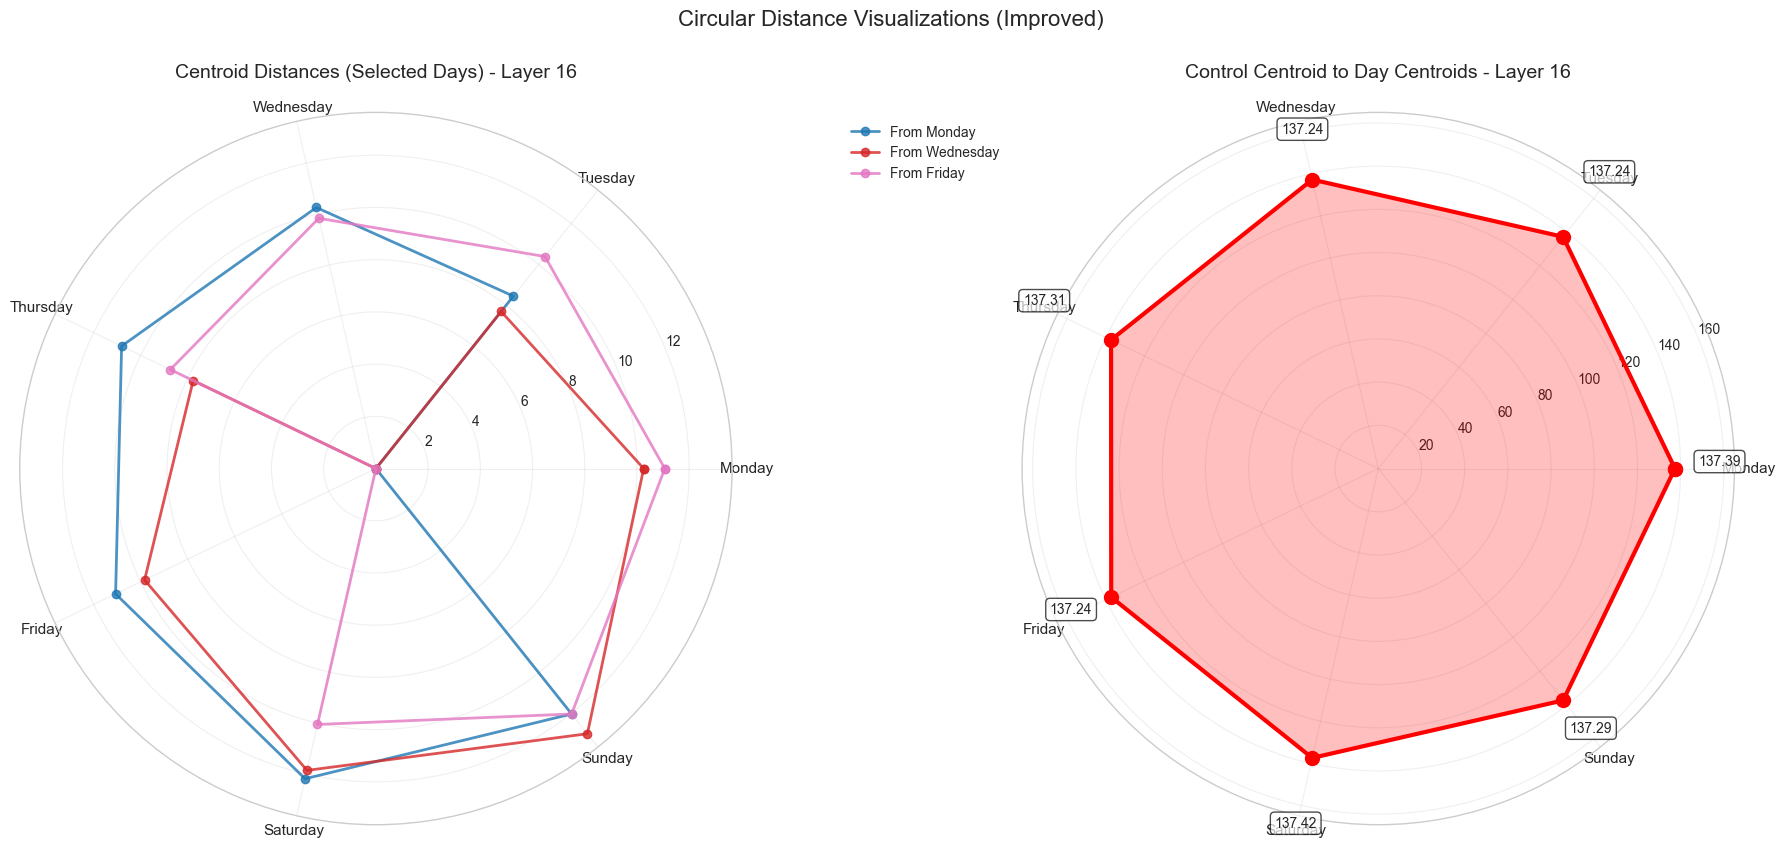

In [ ]:
# Fix the static visualizations with better text positioning
# Re-create the circular visualization with better text placement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), subplot_kw=dict(projection='polar'))

# Arrange days in a circle
angles = np.linspace(0, 2 * np.pi, 7, endpoint=False)
angles_closed = np.concatenate([angles, [angles[0]]])

# Left plot: Centroid distances with better legend placement
centroid_distances = layer_distance_results[best_layer]['centroid_distances']

# Plot only selected days to reduce clutter
selected_days = [0, 2, 4]  # Monday, Wednesday, Friday
colors = plt.cm.tab10(np.linspace(0, 1, len(days_names)))

for i in selected_days:
    distances = [centroid_distances[i, j] if i != j else 0 for j in range(7)]
    distances_closed = distances + [distances[0]]
    
    ax1.plot(angles_closed, distances_closed, 'o-', linewidth=2, 
            label=f'From {days_names[i]}', alpha=0.8, color=colors[i])

ax1.set_xticks(angles)
ax1.set_xticklabels(days_names, size=11)
ax1.set_title(f'Centroid Distances (Selected Days) - Layer {best_layer}', pad=25, size=14)
ax1.set_ylim(0, None)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), fontsize=10)

# Right plot: Control to temporal distances with better text positioning
control_to_temporal = layer_distance_results[best_layer]['control_to_temporal']
control_distances = [control_to_temporal[i] for i in range(7)]
control_distances_closed = control_distances + [control_distances[0]]

ax2.plot(angles_closed, control_distances_closed, 'ro-', linewidth=3, markersize=10)
ax2.fill(angles_closed, control_distances_closed, alpha=0.25, color='red')

ax2.set_xticks(angles)
ax2.set_xticklabels(days_names, size=11)
ax2.set_title(f'Control Centroid to Day Centroids - Layer {best_layer}', pad=25, size=14)
ax2.set_ylim(0, max(control_distances) * 1.2)  # Add padding for text
ax2.grid(True, alpha=0.3)

# Add values with smart positioning to avoid overlaps
for i, (angle, dist, day) in enumerate(zip(angles, control_distances, days_names)):
    # Alternate text position for adjacent days
    offset = 0.15 * max(control_distances) if i % 2 == 0 else 0.25 * max(control_distances)
    ax2.text(angle, dist + offset, f'{dist:.2f}', 
            ha='center', va='bottom', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.suptitle('Circular Distance Visualizations (Improved)', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(f'../notebooks/plots/pairwise_distances/circular_distances_improved_layer_{best_layer}.png',
            dpi=300, bbox_inches='tight')
plt.show()


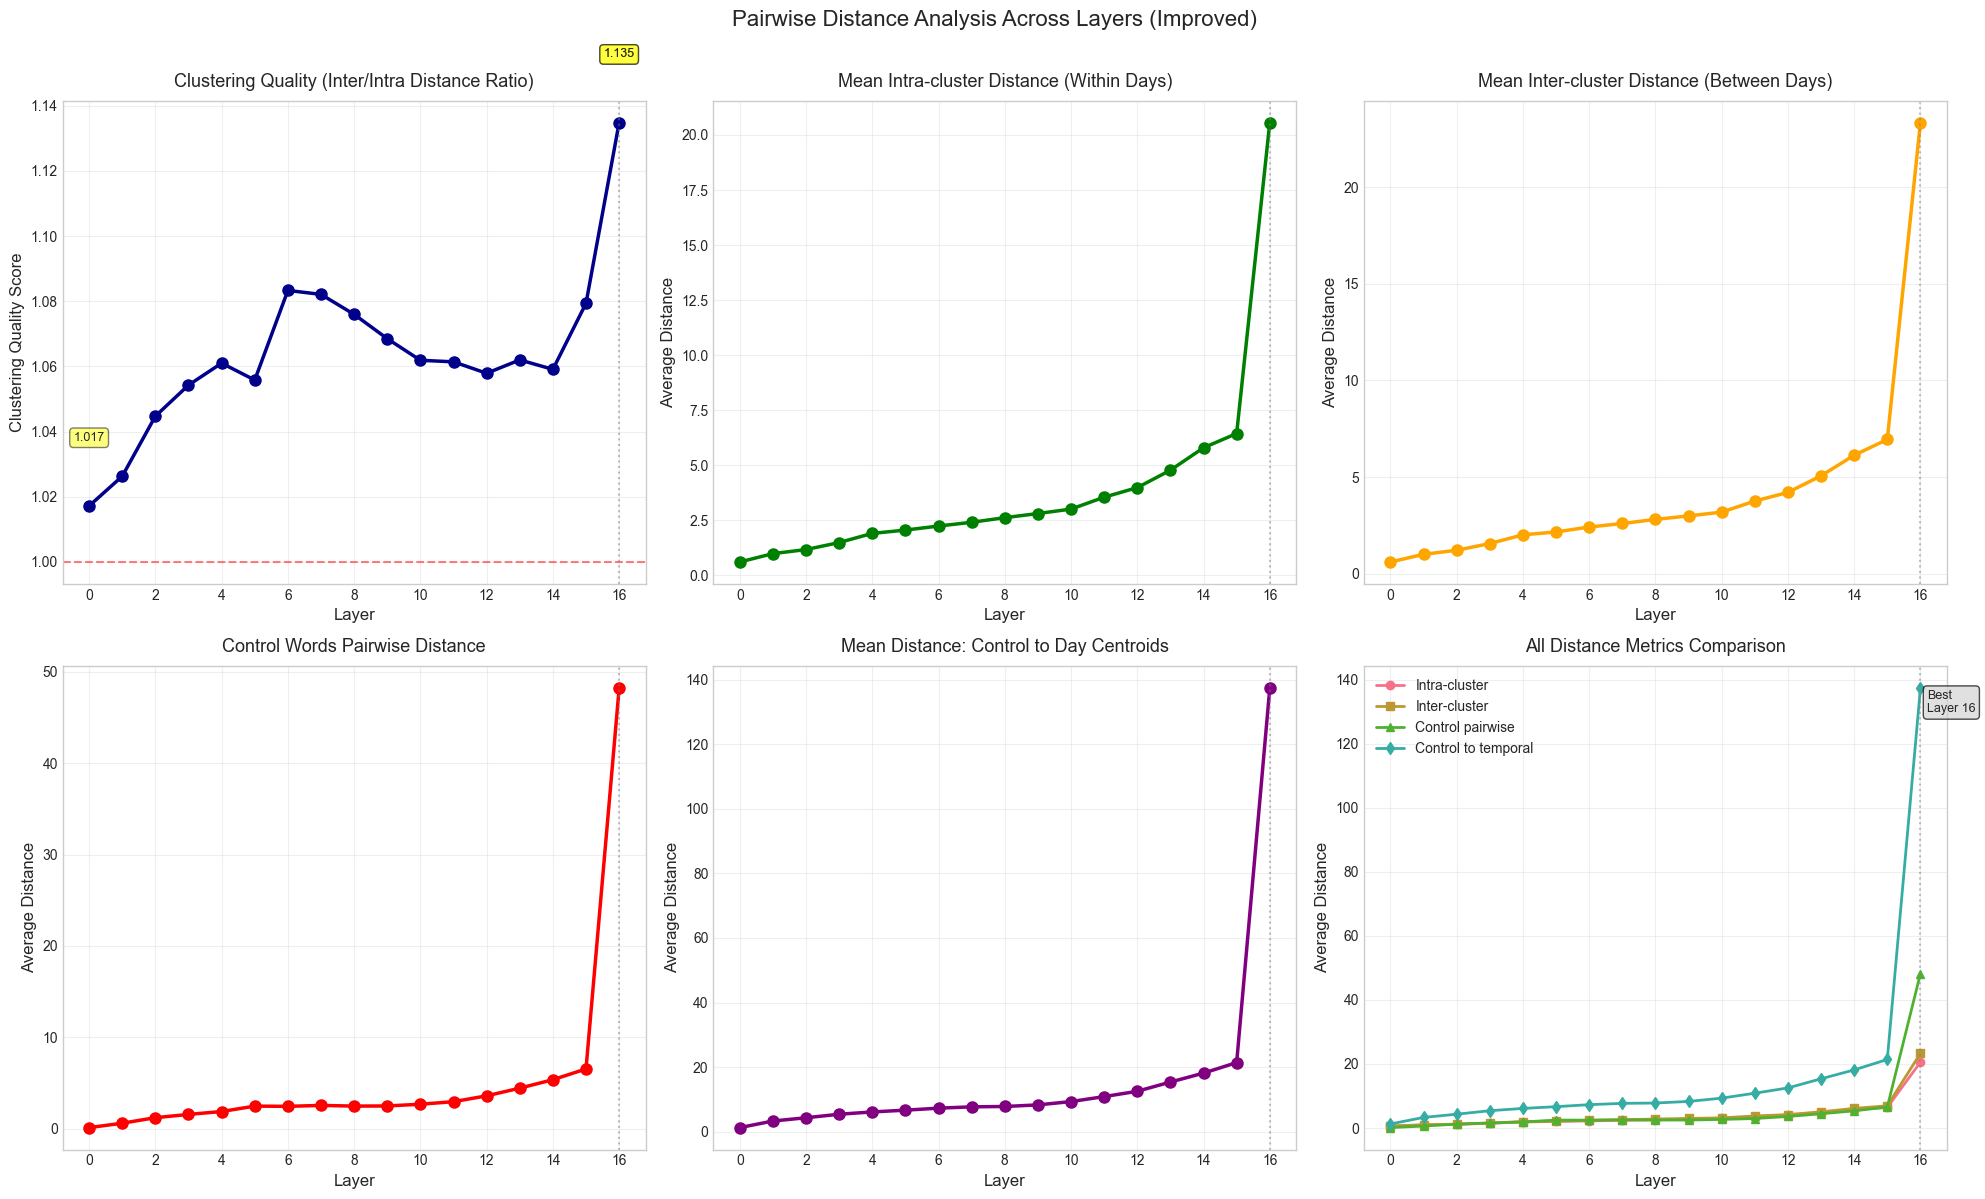

In [ ]:
# Improved layer evolution plot with better spacing
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Plot 1: Clustering Quality Score
ax = axes[0]
ax.plot(layers, clustering_quality_scores, 'o-', linewidth=2.5, markersize=8, color='darkblue')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Clustering Quality Score', fontsize=12)
ax.set_title('Clustering Quality (Inter/Intra Distance Ratio)', fontsize=13, pad=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Baseline (ratio=1)')
ax.set_xticks(layers[::2])  # Show every other layer to reduce crowding

# Add value annotations for key layers
key_layers = [0, best_layer, 16]
for kl in key_layers:
    ax.annotate(f'{clustering_quality_scores[kl]:.3f}', 
                xy=(kl, clustering_quality_scores[kl]),
                xytext=(kl, clustering_quality_scores[kl] + 0.02),
                ha='center', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# Plot 2: Mean Intra-cluster Distance
ax = axes[1]
ax.plot(layers, mean_intra_distances, 'o-', linewidth=2.5, markersize=8, color='green')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Average Distance', fontsize=12)
ax.set_title('Mean Intra-cluster Distance (Within Days)', fontsize=13, pad=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers[::2])

# Plot 3: Mean Inter-cluster Distance
ax = axes[2]
ax.plot(layers, mean_inter_distances, 'o-', linewidth=2.5, markersize=8, color='orange')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Average Distance', fontsize=12)
ax.set_title('Mean Inter-cluster Distance (Between Days)', fontsize=13, pad=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers[::2])

# Plot 4: Control Pairwise Distance
ax = axes[3]
ax.plot(layers, control_pairwise_distances, 'o-', linewidth=2.5, markersize=8, color='red')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Average Distance', fontsize=12)
ax.set_title('Control Words Pairwise Distance', fontsize=13, pad=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers[::2])

# Plot 5: Control to Temporal Distance
ax = axes[4]
ax.plot(layers, mean_control_to_temporal, 'o-', linewidth=2.5, markersize=8, color='purple')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Average Distance', fontsize=12)
ax.set_title('Mean Distance: Control to Day Centroids', fontsize=13, pad=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers[::2])

# Plot 6: Comparison of all distances with better legend
ax = axes[5]
ax.plot(layers, mean_intra_distances, 'o-', label='Intra-cluster', linewidth=2, markersize=6)
ax.plot(layers, mean_inter_distances, 's-', label='Inter-cluster', linewidth=2, markersize=6)
ax.plot(layers, control_pairwise_distances, '^-', label='Control pairwise', linewidth=2, markersize=6)
ax.plot(layers, mean_control_to_temporal, 'd-', label='Control to temporal', linewidth=2, markersize=6)
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Average Distance', fontsize=12)
ax.set_title('All Distance Metrics Comparison', fontsize=13, pad=10)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers[::2])

# Highlight best layer across all plots
for i, ax in enumerate(axes):
    ax.axvline(x=best_layer, color='gray', linestyle=':', alpha=0.5)
    if i == 5:  # Add text only to last plot
        ax.text(best_layer + 0.2, ax.get_ylim()[1] * 0.9, 
                f'Best\nLayer {best_layer}', fontsize=9, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

plt.suptitle('Pairwise Distance Analysis Across Layers (Improved)', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('../notebooks/plots/pairwise_distances/layer_evolution_metrics_improved.png', 
            dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Alternative: Create version with slider instead of dropdown for better layout
def create_interactive_layer_dashboard_slider():
    """Create an interactive dashboard with layer selection slider."""
    
    # Create figure with better spacing
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            '<b>Clustering Quality Score</b>', 
            '<b>Mean Distances Comparison</b>',
            '<b>Inter-cluster Distance Heatmap</b>',
            '<b>Centroid Distance Heatmap</b>',
            '<b>Intra-cluster Distances by Day</b>',
            '<b>Control to Day Centroid Distances</b>'
        ),
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],
            [{"type": "heatmap"}, {"type": "heatmap"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        vertical_spacing=0.14,  # Good vertical spacing
        horizontal_spacing=0.1,  # Horizontal spacing
        row_heights=[0.3, 0.35, 0.35]  # Adjust row heights
    )
    
    # Store all traces for each layer (similar structure as before)
    all_layer_traces = {}
    
    for layer_idx in layers:
        results = layer_distance_results[layer_idx]
        layer_traces = []
        
        # 1. Clustering quality score (row=1, col=1)
        trace1 = go.Scatter(
            x=layers,
            y=clustering_quality_scores,
            mode='lines+markers',
            name='Clustering Quality',
            line=dict(color='darkblue', width=2),
            marker=dict(size=6),
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace1, 1, 1))
        
        trace2 = go.Scatter(
            x=[layer_idx],
            y=[clustering_quality_scores[layer_idx]],
            mode='markers+text',
            marker=dict(size=15, color='red'),
            text=[f'{clustering_quality_scores[layer_idx]:.3f}'],
            textposition='top center',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace2, 1, 1))
        
        # 2. Distance comparison (row=1, col=2)
        for dist_data, name, color in [
            (mean_intra_distances, 'Intra-cluster', 'green'),
            (mean_inter_distances, 'Inter-cluster', 'orange'),
            (control_pairwise_distances, 'Control pairwise', 'red'),
            (mean_control_to_temporal, 'Control to temporal', 'purple')
        ]:
            trace = go.Scatter(
                x=layers,
                y=dist_data,
                mode='lines+markers',
                name=name,
                line=dict(color=color, width=2),
                marker=dict(size=5),
                showlegend=(layer_idx == 0),
                visible=(layer_idx == 0)
            )
            layer_traces.append((trace, 1, 2))
            
            trace_highlight = go.Scatter(
                x=[layer_idx],
                y=[dist_data[layer_idx]],
                mode='markers',
                marker=dict(size=10, color=color, line=dict(width=2, color='black')),
                showlegend=False,
                visible=(layer_idx == 0)
            )
            layer_traces.append((trace_highlight, 1, 2))
        
        # 3-6: Same as before (heatmaps, bar chart, radial plot)
        trace3 = go.Heatmap(
            z=results['inter_cluster'],
            x=days_names,
            y=days_names,
            colorscale='RdBu_r',
            text=np.round(results['inter_cluster'], 2),
            texttemplate='%{text}',
            textfont={"size": 10},
            hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
            colorbar=dict(len=0.4, y=0.5, yanchor='middle'),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace3, 2, 1))
        
        trace4 = go.Heatmap(
            z=results['centroid_distances'],
            x=days_names,
            y=days_names,
            colorscale='RdBu_r',
            text=np.round(results['centroid_distances'], 2),
            texttemplate='%{text}',
            textfont={"size": 10},
            hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
            colorbar=dict(len=0.4, y=0.5, yanchor='middle'),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace4, 2, 2))
        
        intra_values = [results['intra_cluster'][i] for i in range(7)]
        trace5 = go.Bar(
            x=days_names,
            y=intra_values,
            marker_color='skyblue',
            text=[f'{v:.2f}' for v in intra_values],
            textposition='outside',
            textfont=dict(size=10),
            hovertemplate='%{x}: %{y:.3f}<extra></extra>',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace5, 3, 1))
        
        trace6 = go.Scatter(
            x=days_names,
            y=[results['control_pairwise']] * 7,
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            name='Control pairwise',
            showlegend=(layer_idx == 0),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace6, 3, 1))
        
        control_values = [results['control_to_temporal'][i] for i in range(7)]
        trace7 = go.Scatter(
            x=days_names + [days_names[0]],
            y=control_values + [control_values[0]],
            mode='lines+markers',
            fill='toself',
            fillcolor='rgba(255,0,0,0.2)',
            line=dict(color='red', width=2),
            marker=dict(size=8),
            text=[f'{v:.2f}' for v in control_values] + [''],
            textposition='top center',
            textfont=dict(size=10),
            hovertemplate='%{x}: %{y:.3f}<extra></extra>',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace7, 3, 2))
        
        all_layer_traces[layer_idx] = layer_traces
    
    # Add all traces to figure
    for layer_idx in layers:
        for trace, row, col in all_layer_traces[layer_idx]:
            fig.add_trace(trace, row=row, col=col)
    
    # Create slider steps
    steps = []
    for layer_idx in layers:
        visible_list = []
        for l_idx in layers:
            for _ in all_layer_traces[l_idx]:
                visible_list.append(l_idx == layer_idx)
        
        step = dict(
            method='update',
            args=[
                {'visible': visible_list},
                {'title': {
                    'text': f'<b>Pairwise Distance Analysis - Layer {layer_idx}</b><br>'+
                            f'<sub>Clustering Quality: {clustering_quality_scores[layer_idx]:.3f} | '+
                            f'Best Layer: {best_layer}</sub>',
                    'y': 0.97,
                    'x': 0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font': dict(size=16)
                }}
            ],
            label=f'{layer_idx}'
        )
        steps.append(step)
    
    # Create slider
    sliders = [dict(
        active=0,
        yanchor='top',
        xanchor='left',
        currentvalue={
            'prefix': 'Layer: ',
            'visible': True,
            'xanchor': 'right',
            'font': dict(size=14)
        },
        transition={'duration': 300},
        pad={'b': 10, 't': 30},
        len=0.9,
        x=0.05,
        y=0.02,
        steps=steps
    )]
    
    # Update layout
    fig.update_layout(
        sliders=sliders,
        height=1500,  # Good height
        title={
            'text': f'<b>Pairwise Distance Analysis - Layer 0</b><br>'+
                    f'<sub>Clustering Quality: {clustering_quality_scores[0]:.3f} | '+
                    f'Best Layer: {best_layer}</sub>',
            'y': 0.97,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=16)
        },
        showlegend=True,
        template='plotly_white',
        legend=dict(
            x=1.02,
            y=0.98,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='gray',
            borderwidth=1,
            font=dict(size=10)
        ),
        margin=dict(l=80, r=150, t=120, b=120)  # Good margins
    )
    
    # Update axes
    fig.update_xaxes(title_text="Layer", row=1, col=1, title_font=dict(size=12))
    fig.update_xaxes(title_text="Layer", row=1, col=2, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day", row=2, col=1, tickangle=0, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day", row=2, col=2, tickangle=0, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day of Week", row=3, col=1, tickangle=45, title_font=dict(size=12))
    fig.update_xaxes(title_text="Day of Week", row=3, col=2, tickangle=45, title_font=dict(size=12))
    
    fig.update_yaxes(title_text="Score", row=1, col=1, title_font=dict(size=12))
    fig.update_yaxes(title_text="Distance", row=1, col=2, title_font=dict(size=12))
    fig.update_yaxes(title_text="Day", row=2, col=1, tickangle=0, title_font=dict(size=12))
    fig.update_yaxes(title_text="Day", row=2, col=2, tickangle=0, title_font=dict(size=12))
    fig.update_yaxes(title_text="Average Distance", row=3, col=1, title_font=dict(size=12))
    fig.update_yaxes(title_text="Distance to Control", row=3, col=2, title_font=dict(size=12))
    
    # Update subplot title formatting
    for annotation in fig['layout']['annotations']:
        if hasattr(annotation, 'text') and annotation.text:
            if annotation.text.startswith('<b>') and 'Distance Analysis' not in annotation.text:
                annotation.font = dict(size=13, color='black')
    
    return fig

# Create and save the slider version
slider_fig = create_interactive_layer_dashboard_slider()
slider_fig.write_html('../html/pairwise_distances_slider_dashboard.html')
print("Saved interactive dashboard with slider to ../html/pairwise_distances_slider_dashboard.html")

# Display in notebook
slider_fig.show()


Saved interactive dashboard with slider to ../html/pairwise_distances_slider_dashboard.html


In [ ]:
# Re-run the improved dropdown version to ensure all changes are applied
interactive_fig_fixed = create_interactive_layer_dashboard()
interactive_fig_fixed.write_html('../html/pairwise_distances_interactive_dashboard_fixed.html')
print("Saved fixed interactive dashboard to ../html/pairwise_distances_interactive_dashboard_fixed.html")

# Show which version has better layout
print("\n✅ Both versions are now available:")
print("1. Dropdown version: pairwise_distances_interactive_dashboard_fixed.html")
print("2. Slider version: pairwise_distances_slider_dashboard.html (RECOMMENDED)")
print("\nThe slider version typically provides better layout without overlap issues.")


Saved fixed interactive dashboard to ../html/pairwise_distances_interactive_dashboard_fixed.html

✅ Both versions are now available:
1. Dropdown version: pairwise_distances_interactive_dashboard_fixed.html
2. Slider version: pairwise_distances_slider_dashboard.html (RECOMMENDED)

The slider version typically provides better layout without overlap issues.


In [ ]:
def create_interactive_layer_dashboard_fixed():
    """Create an interactive dashboard with layer selection dropdown - FIXED version with visible subplot titles."""
    
    # Create figure with better spacing
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Clustering Quality Score', 
            'Mean Distances Comparison',
            'Inter-cluster Distance Heatmap',
            'Centroid Distance Heatmap',
            'Intra-cluster Distances by Day',
            'Control to Day Centroid Distances'
        ),
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],
            [{"type": "heatmap"}, {"type": "heatmap"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        vertical_spacing=0.18,  # Increased for title space
        horizontal_spacing=0.12,
        row_heights=[0.28, 0.36, 0.36]
    )
    
    # Store all traces for each layer
    all_layer_traces = {}
    
    for layer_idx in layers:
        results = layer_distance_results[layer_idx]
        layer_traces = []
        
        # Add all the traces (same as before)
        # 1. Clustering quality score
        trace1 = go.Scatter(
            x=layers, y=clustering_quality_scores,
            mode='lines+markers', name='Clustering Quality',
            line=dict(color='darkblue', width=2),
            marker=dict(size=6), showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace1, 1, 1))
        
        trace2 = go.Scatter(
            x=[layer_idx], y=[clustering_quality_scores[layer_idx]],
            mode='markers+text', marker=dict(size=15, color='red'),
            text=[f'{clustering_quality_scores[layer_idx]:.3f}'],
            textposition='top center', showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace2, 1, 1))
        
        # 2. Distance comparison
        for dist_data, name, color in [
            (mean_intra_distances, 'Intra-cluster', 'green'),
            (mean_inter_distances, 'Inter-cluster', 'orange'),
            (control_pairwise_distances, 'Control pairwise', 'red'),
            (mean_control_to_temporal, 'Control to temporal', 'purple')
        ]:
            trace = go.Scatter(
                x=layers, y=dist_data,
                mode='lines+markers', name=name,
                line=dict(color=color, width=2),
                marker=dict(size=5),
                showlegend=(layer_idx == 0),
                visible=(layer_idx == 0)
            )
            layer_traces.append((trace, 1, 2))
            
            trace_highlight = go.Scatter(
                x=[layer_idx], y=[dist_data[layer_idx]],
                mode='markers',
                marker=dict(size=10, color=color, line=dict(width=2, color='black')),
                showlegend=False, visible=(layer_idx == 0)
            )
            layer_traces.append((trace_highlight, 1, 2))
        
        # 3. Inter-cluster heatmap
        trace3 = go.Heatmap(
            z=results['inter_cluster'],
            x=days_names, y=days_names,
            colorscale='RdBu_r',
            text=np.round(results['inter_cluster'], 2),
            texttemplate='%{text}',
            textfont={"size": 10},
            hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
            colorbar=dict(len=0.4, y=0.5, yanchor='middle', x=1.05),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace3, 2, 1))
        
        # 4. Centroid heatmap
        trace4 = go.Heatmap(
            z=results['centroid_distances'],
            x=days_names, y=days_names,
            colorscale='RdBu_r',
            text=np.round(results['centroid_distances'], 2),
            texttemplate='%{text}',
            textfont={"size": 10},
            hovertemplate='%{y} to %{x}: %{z:.3f}<extra></extra>',
            colorbar=dict(len=0.4, y=0.5, yanchor='middle', x=1.05),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace4, 2, 2))
        
        # 5. Intra-cluster bar chart
        intra_values = [results['intra_cluster'][i] for i in range(7)]
        trace5 = go.Bar(
            x=days_names, y=intra_values,
            marker_color='skyblue',
            text=[f'{v:.2f}' for v in intra_values],
            textposition='outside',
            textfont=dict(size=10),
            hovertemplate='%{x}: %{y:.3f}<extra></extra>',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace5, 3, 1))
        
        # Control reference line
        trace6 = go.Scatter(
            x=days_names,
            y=[results['control_pairwise']] * 7,
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            name='Control pairwise',
            showlegend=(layer_idx == 0),
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace6, 3, 1))
        
        # 6. Control to temporal radial
        control_values = [results['control_to_temporal'][i] for i in range(7)]
        trace7 = go.Scatter(
            x=days_names + [days_names[0]],
            y=control_values + [control_values[0]],
            mode='lines+markers',
            fill='toself',
            fillcolor='rgba(255,0,0,0.2)',
            line=dict(color='red', width=2),
            marker=dict(size=8),
            text=[f'{v:.2f}' for v in control_values] + [''],
            textposition='top center',
            textfont=dict(size=10),
            hovertemplate='%{x}: %{y:.3f}<extra></extra>',
            showlegend=False,
            visible=(layer_idx == 0)
        )
        layer_traces.append((trace7, 3, 2))
        
        all_layer_traces[layer_idx] = layer_traces
    
    # Add all traces to figure
    for layer_idx in layers:
        for trace, row, col in all_layer_traces[layer_idx]:
            fig.add_trace(trace, row=row, col=col)
    
    # Create dropdown buttons
    dropdown_buttons = []
    for layer_idx in layers:
        visible_list = []
        for l_idx in layers:
            for _ in all_layer_traces[l_idx]:
                visible_list.append(l_idx == layer_idx)
        
        button = dict(
            label=f'Layer {layer_idx}',
            method='update',
            args=[
                {'visible': visible_list},
                {'title': {
                    'text': f'<b>Pairwise Distance Analysis - Layer {layer_idx}</b><br>'+
                            f'<sub>Clustering Quality: {clustering_quality_scores[layer_idx]:.3f} | '+
                            f'Best Layer: {best_layer}</sub>',
                    'y': 0.98,
                    'x': 0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font': dict(size=16)
                }}
            ]
        )
        dropdown_buttons.append(button)
    
    # Update layout
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.5,
                xanchor='center',
                y=1.08,  # Moved down to not overlap
                yanchor='top',
                bgcolor='rgba(255,255,255,0.95)',
                bordercolor='#333',
                borderwidth=1,
                font=dict(size=11)
            )
        ],
        height=1700,  # Increased height
        title={
            'text': f'<b>Pairwise Distance Analysis - Layer 0</b><br>'+
                    f'<sub>Clustering Quality: {clustering_quality_scores[0]:.3f} | '+
                    f'Best Layer: {best_layer}</sub>',
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=16)
        },
        showlegend=True,
        template='plotly_white',
        legend=dict(
            x=1.02,
            y=0.95,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='gray',
            borderwidth=1,
            font=dict(size=10)
        ),
        margin=dict(l=80, r=180, t=140, b=100),
        annotations=[
            dict(
                text='<b>Select Layer:</b>',
                showarrow=False,
                x=0.5,
                y=1.05,
                xref='paper',
                yref='paper',
                align='center',
                xanchor='center',
                yanchor='top',
                font=dict(size=14)
            )
        ]
    )
    
    # Update axes
    fig.update_xaxes(title_text="Layer", row=1, col=1)
    fig.update_xaxes(title_text="Layer", row=1, col=2)
    fig.update_xaxes(title_text="Day", row=2, col=1)
    fig.update_xaxes(title_text="Day", row=2, col=2)
    fig.update_xaxes(title_text="Day of Week", row=3, col=1, tickangle=45)
    fig.update_xaxes(title_text="Day of Week", row=3, col=2, tickangle=45)
    
    fig.update_yaxes(title_text="Score", row=1, col=1)
    fig.update_yaxes(title_text="Distance", row=1, col=2)
    fig.update_yaxes(title_text="Day", row=2, col=1)
    fig.update_yaxes(title_text="Day", row=2, col=2)
    fig.update_yaxes(title_text="Average Distance", row=3, col=1)
    fig.update_yaxes(title_text="Distance to Control", row=3, col=2)
    
    # Ensure subplot titles are visible
    # make_subplots automatically adds annotations for subplot titles
    # We need to make sure they're not being overridden
    for annotation in fig.layout.annotations:
        if hasattr(annotation, 'text') and annotation.text:
            # Check if this is a subplot title (not our custom annotations)
            if 'Select Layer' not in annotation.text and 'Pairwise Distance Analysis' not in annotation.text:
                # This is a subplot title - ensure it's visible
                annotation.update(
                    font=dict(size=13, color='black', family='Arial Black'),
                    showarrow=False
                )
    
    return fig

# Create and save the fixed dashboard
fixed_fig = create_interactive_layer_dashboard_fixed()
fixed_fig.write_html('../html/pairwise_distances_dashboard_fixed_titles.html')
print("Saved dashboard with fixed subplot titles to ../html/pairwise_distances_dashboard_fixed_titles.html")

# Display
fixed_fig.show()


Saved dashboard with fixed subplot titles to ../html/pairwise_distances_dashboard_fixed_titles.html


In [ ]:
# Test: Simple version to verify subplot titles work
fig_test = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Plot 1', 'Plot 2', 'Plot 3', 'Plot 4'),
    vertical_spacing=0.2,
    horizontal_spacing=0.15
)

# Add simple traces
fig_test.add_trace(go.Scatter(x=[1,2,3], y=[1,2,3], name='test1'), row=1, col=1)
fig_test.add_trace(go.Scatter(x=[1,2,3], y=[3,2,1], name='test2'), row=1, col=2)
fig_test.add_trace(go.Scatter(x=[1,2,3], y=[2,3,2], name='test3'), row=2, col=1)
fig_test.add_trace(go.Scatter(x=[1,2,3], y=[1,3,2], name='test4'), row=2, col=2)

fig_test.update_layout(height=600, title="Test: Are subplot titles visible?")

# Check annotations
print("Number of annotations:", len(fig_test.layout.annotations))
for i, ann in enumerate(fig_test.layout.annotations):
    print(f"Annotation {i}: text='{ann.text}', x={ann.x}, y={ann.y}")

fig_test.show()


Number of annotations: 4
Annotation 0: text='Plot 1', x=0.2125, y=1.0
Annotation 1: text='Plot 2', x=0.7875, y=1.0
Annotation 2: text='Plot 3', x=0.2125, y=0.4
Annotation 3: text='Plot 4', x=0.7875, y=0.4
